In [14]:
import numpy as np
import sisl
import z2pack

# TI-02: $\mathbb{Z}_2$ Topological Invariant
In this exercise, we will use Z2Pack to calculate the $\mathbb{Z}_2$ topological invariant of bismuthene. Exercise TI_01 is a prerequisite for this exercise.

## Introduction

### Hybrid Wannier Charge centres

Topological invariants are calculated in Z2Pack [Gresh2017] using Hybrid Wannier Charge Centres (HWCC), who are defined in terms of Hybrid Wannier Functions (HWF). The difference between HWF and Wannier Functions is that the latter is only localized in one direction (for instance, $x$) and delocalized in the others. In 2D, a Hybrid Wannier Function can be written as: 

\begin{align}
|(R_x,k_y), n\rangle = \frac{1}{2\pi}\int\mathrm{d}k_x\; e^{i k_x R_x}|\psi_{n,\mathbf{k}}\rangle
\end{align}

The charge centre of an HWF is defined as the average position of the function in the localized direction. The charge centres are defined modulo the lattice vector $a_x$:

\begin{align}
\bar x_n(k_y) = \langle (R_x,k_y), n | \hat{x} | (R_x,k_y), n\rangle
\end{align}

One can think of an HWCC as the charge centre of a Wannier function in a 1D system, coupled to an external parameter $k_y$. In this interpretation, the sum of all HWCCs is directly linked to the 1D electric polarization
\begin{align}
\mathbf{P}^h_e(k_y) = e \sum_n \bar x_n(k_y)
\end{align}
It should be noted that individual HWCCs are not gauge-invariant. The sum of all HWCCs and $\mathbf{P}^h_e(k_y)$ are gauge-invariant. 

### From HWCC to topological invariants
#### Chern number

Since the HWCCs are defined modulo the lattice vector $R_x$, we can assume periodic boundary conditions $\bar x(k_y) = \bar x(k_y) + a_x$. In this way, $\bar x(k_y)$ can be mapped on a point on the unit circle for any given $k_y$. As $k_y$ goes from 0 to $2\pi$ the HWCCs and electric polarization $P^h_e$ describe trajectories on a cylinder. The winding number of the trajectory of $P^h_e$ gives the Chern number of the system. 

A Chern number can also be uniquely associated with any set of **isolated bands** and corresponds to the number of windings of the polarization of the subset of states. The Chern number of the whole system is equal to sum of the individual Chern numbers.



|<img src="img/FIG_2_Gresch_PhyRevB95_075146_2017.png" alt="Sketch of some possible evolutions of $P^h_e$" style="width: 400px;"/>|
|:---|
|Fig 1: Sketch of some possible evolutions of $P^h_e$ from [Gresh2017]|

#### Time-reversal invariance and the $\mathbb{Z}_2$-invariant

Under time-reversal symmetry, the Hilbert space of occupied states can be split into two subspaces which are mapped onto each other by time-reversal. This splits all Kramer pairs into states which are assigned to different subspaces. The Chern number $C_1$, $C_2$ of the subspaces are not uniquely defined and depend on which states are assigned to which subspace. However, as a consequence of the Chern number being odd under time-reversal, the two Chern numbers are always opposite $C_1=-C_2$, i.e. the Chern number of the full system is always zero.

Further, the two states forming a Kramer pair have to carry opposite Chern numbers. Hence, if the states exchange subspaces, the two Chern numbers can only change by an even number and the $\mathbb{Z}_2$ invariant
\begin{align}
\mathbb{Z}_2 = (C_1 - C_2)/2 (\textrm{mod} 2)
\end{align}
is well defined.

Geometrically the $\mathbb{Z}_2$ invariant is related to the number of times L any line $f(k_y)$ intersects the trajectory of HWCCs on the interval $[0,2\pi]$. 

|<img src="img/FIG_5_Gresch_PhyRevB95_075146_2017.png" alt="Sketch of some possible evolutions of HWCCs" style="width: 400px;"/>|
|:---|
|Fig :2 Sketch of possible evolutions of HWCCs (red and blue lines) for a system with two occupied bands and time-reversal symmetry. Taken from [Gresh2017]|

Note: In Z2Pack $f(k_y)$ is defined as the middle of the largest gap between two neighbouring HWCCs. This choice is favorable for numerical stability.

_References for content and images:_

[Gresh2017] Dominik Gresch et al., Phys. Rev. B **95**, 075146 (2017), "Z2Pack: Numerical implementation of hybrid Wannier centres for identifying topological materials", doi: [10.1103/PhysRevB.95.075146](https://doi.org/10.1103/PhysRevB.95.075146)

## Hands-on tutorial

In order to run Z2Pack we need to provide information about the Hamiltonian, overlap and the orbital positions.
We start off by reading the geometry and hamiltonian from siesta output.

In [15]:
sile = sisl.get_sile('siesta_work/Bi2D_BHex.fdf')
geom = sile.read_geometry()
H = sile.read_hamiltonian(geometry=geom)

We will create a ``hm`` system in Z2Pack ([doc](http://z2pack.ethz.ch/doc/2.1/reference/hm.html)). This interface expects two functions: one returning the Hamiltonian matrix and one the overlap matrix for any given k-vector.


In [16]:
Hk = lambda k: H.Hk(k=k, dtype=np.complex64, format='array')
Sk = lambda k: H.Sk(k=k, dtype=np.complex64, format='array')

Next, we need the positions of all orbitals in fractional coordinates. Note that the matrix elements are ordered in 2x2 blocks corresponding to spin-up and spin-down version of the same basis orbital. So we need to create a list of positions with the same order.

In [17]:
pos = geom.fxyz[list(map(geom.o2a, np.arange(H.no)))]
pos = np.repeat(pos, 2, axis=0)

Now we can create the system in Z2Pack. For now, we will only look at the two highest occupied bands. They are degenerate (Kramer degeneracy) and isolated from the rest of the occupied bands, which allows us to uniquely associate a $\mathbb{Z}_2$ invariant with this pair.


In [18]:
system_hocc = z2pack.hm.System(
        hamilton=Hk,
        hermitian_tol=1e-5,
        overlap=Sk,
        pos=pos,
        bands=[28,29],
)

### Running a HWCC calculation
In order to get the $\mathbb{Z}_2$ invariant, we need to specify 
1. in which direction the trajectories of the HWF should be evaluated and
2. in which direction the HWF are localized

This defines a surface in k-space, which is periodic in one direction and covers half of the BZ in the other. To pass this information to Z2Pack, we need to define a function $S$ that is periodic in the second argument and covers half a period in the second argument. The domain is always $[0,1]^2$ and the function has to map onto vectors in reciprocal space (in fractional coordinates).
\begin{align}
&S: [0,1]^2 \rightarrow \mathbb{R}^3 \\
&S(s,1) = S(s,0) + \mathbf{G} \\
&S(1,t) = S(0,t) + \frac{1}{2}\mathbf{G}'
\end{align}

In our example we want to calculate the HWCCs along $k_x$ and trace the evolutions for $k_y$ from $0$ to $\pi$.
\begin{align}
&S(s,1) = S(s, 0) + (1, 0, 0) \\
&S(1,t) = S(0,t) + (0, 0.5, 0)
\end{align}

In [19]:
surface=lambda s, t: [t, s/2, 0]

There are three diffrent convergence criteria in Z2Pack:
1. Positions of the HWCCs on a line: The code checks how much the positions of the HWCCs change as the as more k-points are used. The tolerance for this check is set by the flag ``pos_tol``. If the change is larger than the tolerance more k-points will be use. The numbers of k-point are controlled via the flag ``iterator``. 
2. Movement of the HWCCs between lines: The code checks how much the position of the HWCCs changes from one line to the next. The tolerance for this check is set by the flag ``move_tol``. If the check fails a new line is added in between. The initial number of lines is controlled via the flag ``num_lines`` and the lower limit for the distance between two line is controll via ``min_neighbour_dis``.
3. Gap position: The code check how big the distance between the position of the gap and the position of HWCCs in neighbouring lines are. The tolerance for this check is set by the flag ``gap_tol``. If the check fails a new line is added in between. The initial number of lines is controlled via the flag ``num_lines`` and the lower limit for the distance between two line is controll via ``min_neighbour_dis``.

In [20]:
# Run the WCC calculations
settings = {'num_lines': 11,
            'pos_tol': 1e-2,
            'gap_tol': 2e-2,
            'move_tol': 0.3,
            'iterator': range(8, 27, 2),
            'min_neighbour_dist': 1e-2,
            'load': False,
}

result_hocc = z2pack.surface.run(
    system=system_hocc,
    surface=surface,
    save_file='./res_hocc.json',
    **settings
)


+----------------------------------------------------------------------+
|   ===================                                                |
|   SURFACE CALCULATION                                                |
|   ===================                                                |
|   starting at 2020-02-26 11:39:38,781                                |
|   running Z2Pack version 2.1.1                                       |
|                                                                      |
|   gap_tol:            0.02                                           |
|   init_result:        None                                           |
|   iterator:           range(8, 27, 2)                                |
|   load:               False                                          |
|   load_quiet:         True                                           |
|   min_neighbour_dist: 0.01                                           |
|   move_tol:           0.3                       

In [21]:
print("Z2 invariant of the two highest, occupied bands: {}".format(z2pack.invariant.z2(result_hocc)))

Z2 invariant of the two highest, occupied bands: 1


We can visualize the HWCCs and the gap position:

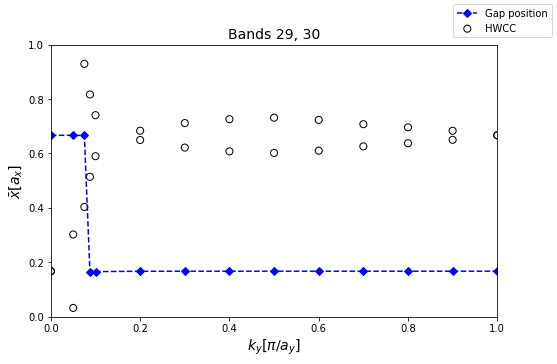

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(8,5))
wcc_settings={'s': 50., 'lw': 1., 'facecolor': 'none', 'edgecolors': 'k', 'label':'HWCC'}
gap_settings={'marker': 'D', 'color': 'b', 'linestyle': '--', 'label':'Gap position'}

z2pack.plot.wcc(result_hocc, axis=ax, wcc_settings=wcc_settings, gap_settings=gap_settings)
ax.set_title('Bands 29, 30', fontsize=14)
ax.set_ylabel(r'$\bar{x} [a_x]$', fontsize=14)
ax.set_xlabel(r'$k_y [\pi/a_y]$', fontsize=14)
handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys())
plt.show()

## Exercises
1. To get a feeling for the different options, one should play with them. Use a small number of lines and try different combinations of parameters. Even if a calculation did not converge, the HWCCs can be visualized. This allows us to see why a certain convergence check failed.

2. Calculate the $\mathbb{Z}_2$ invariant for the whole system. In the last exercise (TI-01) we visualized the band structure. We can go back and adjust the range on the y-axis to get an idea of which sets of bands are isolated from others. There are different ways of splitting bands in sets, but all should give the same invariant when they are summed.

   _Hint: Running a calculation with all 30 bands, might be tricky to converge._

### 2 a) Running the 28 lower bands at once:

In [23]:
system_lower = z2pack.hm.System(
        hamilton=Hk,
        hermitian_tol=1e-5,
        overlap=Sk,
        pos=pos,
        bands=range(28),
)
settings = {'num_lines': 11,
            'pos_tol': 1e-2,
            'gap_tol': 2e-2,
            'move_tol': 0.3,
            'iterator': range(8, 58, 2),
            'min_neighbour_dist': 1e-3,
            'load': False,
}

result_lower = z2pack.surface.run(
    system=system_lower,
    surface=surface,
    save_file='./res_lower.json',
    **settings
)


+----------------------------------------------------------------------+
|   ===================                                                |
|   SURFACE CALCULATION                                                |
|   ===================                                                |
|   starting at 2020-02-26 11:39:49,237                                |
|   running Z2Pack version 2.1.1                                       |
|                                                                      |
|   gap_tol:            0.02                                           |
|   init_result:        None                                           |
|   iterator:           range(8, 58, 2)                                |
|   load:               False                                          |
|   load_quiet:         True                                           |
|   min_neighbour_dist: 0.001                                          |
|   move_tol:           0.3                       

INFO: Saving surface result to file ./res_lower.json (ASYNC)
INFO:       Calculating line for N = 14
INFO:       Calculating line for N = 16
INFO:       Calculating line for N = 18
INFO:       Calculating line for N = 20
INFO:       Calculating line for N = 22
INFO:       Calculating line for N = 24
INFO:       Calculating line for N = 26
INFO:       Calculating line for N = 28
INFO:       Calculating line for N = 30
INFO: Convergence criteria fulfilled for 9 of 10 neighbouring lines.
INFO: Adding line at t = 0.35000000000000003
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO:       Calculating line for N = 12
INFO:       Calculating line for N = 14
INFO:       Calculating line for N = 16
INFO:       Calculating line for N = 18
INFO:       Calculating line for N = 20
INFO:       Calculating line for N = 22
INFO:       Calculating line for N = 24
INFO:       Calculating line for N = 26
INFO:       Calculating line for N = 28
INFO:       Calculating li

In [24]:
print("Z2 invariant of the 28 lowest bands: {}".format(
    z2pack.invariant.z2(result_lower)
))
print("Z2 invariant of the full system : {}".format(
    (z2pack.invariant.z2(result_hocc)
     + z2pack.invariant.z2(result_lower)) % 2
))

Z2 invariant of the 28 lowest bands: 0
Z2 invariant of the full system : 1


### 2 b) Running every Kramer pair (including (28,29))

In [25]:
settings = {'num_lines': 11,
            'pos_tol': 1e-2,
            'gap_tol': 2e-2,
            'move_tol': 0.3,
            'iterator': range(8, 27, 2),
            'min_neighbour_dist': 1e-2,
            'load': False,
}

n_pairs = 15
Z2 = np.zeros((n_pairs,), dtype=int)
for i in range(n_pairs):
    system = z2pack.hm.System(
            hamilton=Hk,
            hermitian_tol=1e-5,
            overlap=Sk,
            pos=pos,
            bands=[2*i, 2*i+1],
    )

    result = z2pack.surface.run(
        system=system,
        surface=surface,
        **settings
    )
    Z2[i] = z2pack.invariant.z2(result)




+----------------------------------------------------------------------+
|   ===================                                                |
|   SURFACE CALCULATION                                                |
|   ===================                                                |
|   starting at 2020-02-26 11:43:28,272                                |
|   running Z2Pack version 2.1.1                                       |
|                                                                      |
|   gap_tol:            0.02                                           |
|   init_result:        None                                           |
|   iterator:           range(8, 27, 2)                                |
|   load:               False                                          |
|   load_quiet:         True                                           |
|   min_neighbour_dist: 0.01                                           |
|   move_tol:           0.3                       

INFO: Adding line at t = 0.05
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Convergence criteria fulfilled for 10 of 11 neighbouring lines.
INFO: Adding line at t = 0.025
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Convergence criteria fulfilled for 12 of 12 neighbouring lines.

+----------------------------------------------------------------------+
|                   Calculation finished in 0h 0m 1s                   |
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
|                         ==================                           |
|                         CONVERGENCE REPORT                           |
|                         ==================                           |
|                                                                      |
|                         Line Convergence             

INFO: Adding lines required by 'num_lines'.
INFO: Adding line at t = 0.0
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.1
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO:       Calculating line for N = 12
INFO: Adding line at t = 0.2
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO:       Calculating line for N = 12
INFO: Adding line at t = 0.30000000000000004
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO:       Calculating line for N = 12
INFO:       Calculating line for N = 14
INFO: Adding line at t = 0.4
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO:       Calculating line for N = 12
INFO:       Calculating line for N = 14
INFO: Adding line at t = 0.5
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO:       Calculating line for N = 12
INFO:       


+----------------------------------------------------------------------+
|   ===================                                                |
|   SURFACE CALCULATION                                                |
|   ===================                                                |
|   starting at 2020-02-26 11:43:33,403                                |
|   running Z2Pack version 2.1.1                                       |
|                                                                      |
|   gap_tol:            0.02                                           |
|   init_result:        None                                           |
|   iterator:           range(8, 27, 2)                                |
|   load:               False                                          |
|   load_quiet:         True                                           |
|   min_neighbour_dist: 0.01                                           |
|   move_tol:           0.3                       

INFO: Adding line at t = 0.8
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO:       Calculating line for N = 12
INFO: Adding line at t = 0.9
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 1.0
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Convergence criteria fulfilled for 8 of 10 neighbouring lines.
INFO: Adding line at t = 0.05
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.95
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Convergence criteria fulfilled for 12 of 12 neighbouring lines.

+----------------------------------------------------------------------+
|                   Calculation finished in 0h 0m 1s                   |
+----------------------------------------------------------------------+

+---------------------------------------------------------

INFO: Adding lines required by 'num_lines'.
INFO: Adding line at t = 0.0
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.1
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.2
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.30000000000000004
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.4
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.5
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.6000000000000001
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.7000000000000001
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.8
INFO:       Calcu

INFO: Adding lines required by 'num_lines'.
INFO: Adding line at t = 0.0
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.1
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.2
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.30000000000000004
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.4
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.5
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO:       Calculating line for N = 12
INFO: Adding line at t = 0.6000000000000001
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO:       Calculating line for N = 12
INFO:       Calculating line for N = 14
INFO: Adding line at t = 0.7000000000000001
INFO:

INFO: Convergence criteria fulfilled for 10 of 11 neighbouring lines.
INFO: Adding line at t = 0.675
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO:       Calculating line for N = 12
INFO:       Calculating line for N = 14
INFO:       Calculating line for N = 16
INFO:       Calculating line for N = 18
INFO:       Calculating line for N = 20
INFO:       Calculating line for N = 22
INFO:       Calculating line for N = 24
INFO:       Calculating line for N = 26
INFO: Convergence criteria fulfilled for 11 of 12 neighbouring lines.
INFO: Adding line at t = 0.6625000000000001
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO:       Calculating line for N = 12
INFO:       Calculating line for N = 14
INFO:       Calculating line for N = 16
INFO:       Calculating line for N = 18
INFO:       Calculating line for N = 20
INFO:       Calculating line for N = 22
INFO:       Calculating line for N = 24
INFO:       Calculating lin

INFO: Adding lines required by 'num_lines'.
INFO: Adding line at t = 0.0
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.1
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.2
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.30000000000000004
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO: Adding line at t = 0.4
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO:       Calculating line for N = 12
INFO: Adding line at t = 0.5
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO:       Calculating line for N = 12
INFO:       Calculating line for N = 14
INFO: Adding line at t = 0.6000000000000001
INFO:       Calculating line for N = 8
INFO:       Calculating line for N = 10
INFO:       Calculating line for N = 12
INFO:    

In [26]:
for i in range(n_pairs):
    print("({: 3d}, {: 3d}): {:1d}".format(2*i+1, 2*i+2, Z2[i]))
print('-'*13)
print('       Sum: {:1d}'.format(np.sum(Z2) % 2))

(  1,   2): 1
(  3,   4): 1
(  5,   6): 1
(  7,   8): 1
(  9,  10): 1
( 11,  12): 1
( 13,  14): 0
( 15,  16): 0
( 17,  18): 0
( 19,  20): 0
( 21,  22): 1
( 23,  24): 1
( 25,  26): 0
( 27,  28): 0
( 29,  30): 1
-------------
       Sum: 1
